##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Modeling with Joint Distribution

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

`JointDistributionSequential` is a newly introduced distribution-like Class that empowers users to fast prototype Bayesian model. It lets you chain multiple distributions together, and use lambda function to introduce dependencies. This is designed to build small- to medium- size Bayesian models, including many commonly used models like GLMs, mixed effect models, mixture models, and more. It enables all the necessary features for a Bayesian workflow: prior predictive sampling,  It could be plug-in to another larger Bayesian Graphical model or neural network. In this Colab, we will show some examples of how to use `JointDistributionSequential` to achieve your day to day Bayesian workflow


### Dependencies & Prerequisites


In [0]:
#@title Install { display-mode: "form" }
TF_Installation = 'TF2 Nightly (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)', 'TF1 Nightly (GPU)', 'TF1 Stable (GPU)','System']

if TF_Installation == 'TF2 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu-2.0-preview
  print('Installation of `tf-nightly-gpu-2.0-preview` complete.')
elif TF_Installation == 'TF2 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
  print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')
elif TF_Installation == 'TF1 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu
  print('Installation of `tf-nightly-gpu` complete.')
elif TF_Installation == 'TF1 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu
  print('Installation of `tensorflow-gpu` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [0]:
# We will be using ArviZ, a multi-backend Bayesian diagnosis and plotting library
!pip3 install -q git+git://github.com/arviz-devs/arviz.git

In [0]:
#@title Import and set ups{ display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [0]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

## JointDistribution

Notes: This distribution class is useful when you just have a simple model. "Simple" means chain-like graphs; although the approach technically works for any PGM with degree at most 255 for a single node (Because Python functions can have at most this many args).

The basic idea is to have the user specify a list of `callable`s which produce `tfp.Distribution` instances, one for every vertex in their [PGM](https://en.wikipedia.org/wiki/Graphical_model). The `callable` will have at most as many arguments as its index in the list. (For user convenience, aguments will be passed in reverse order of creation.)  Internally we'll "walk the graph" simply by passing every previous RV's value into each callable. In so doing we implement the [chain rule of probablity](https://en.wikipedia.org/wiki/Chain_rule_(probability%29#More_than_two_random_variables): $p(\{x\}_i^d)=\prod_i^d p(x_i|x_{<i})$.

The idea is pretty simple, even as Python code. Here's the gist:

```python
# The chain rule of probability, manifest as Python code.
def log_prob(rvs, xs):
  # xs[:i] is rv[i]'s maximal blanket. `[::-1]` just reverses the list.
  return sum(rv(*xs[i-1::-1]).log_prob(xs[i])
             for i, rv in enumerate(rvs))
```

You can find more information from the docstring of `JointDistributionSequential`, but the gist is that you pass a list of distributions to initialize the Class, if some distributions in the list is depending on output from another upstream distribution/variable, you just wrap it with a lambda function. Now let's see how it works in action!

## (Robust) Linear regression

From PyMC3 doc [GLM: Robust Regression with Outlier Detection](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


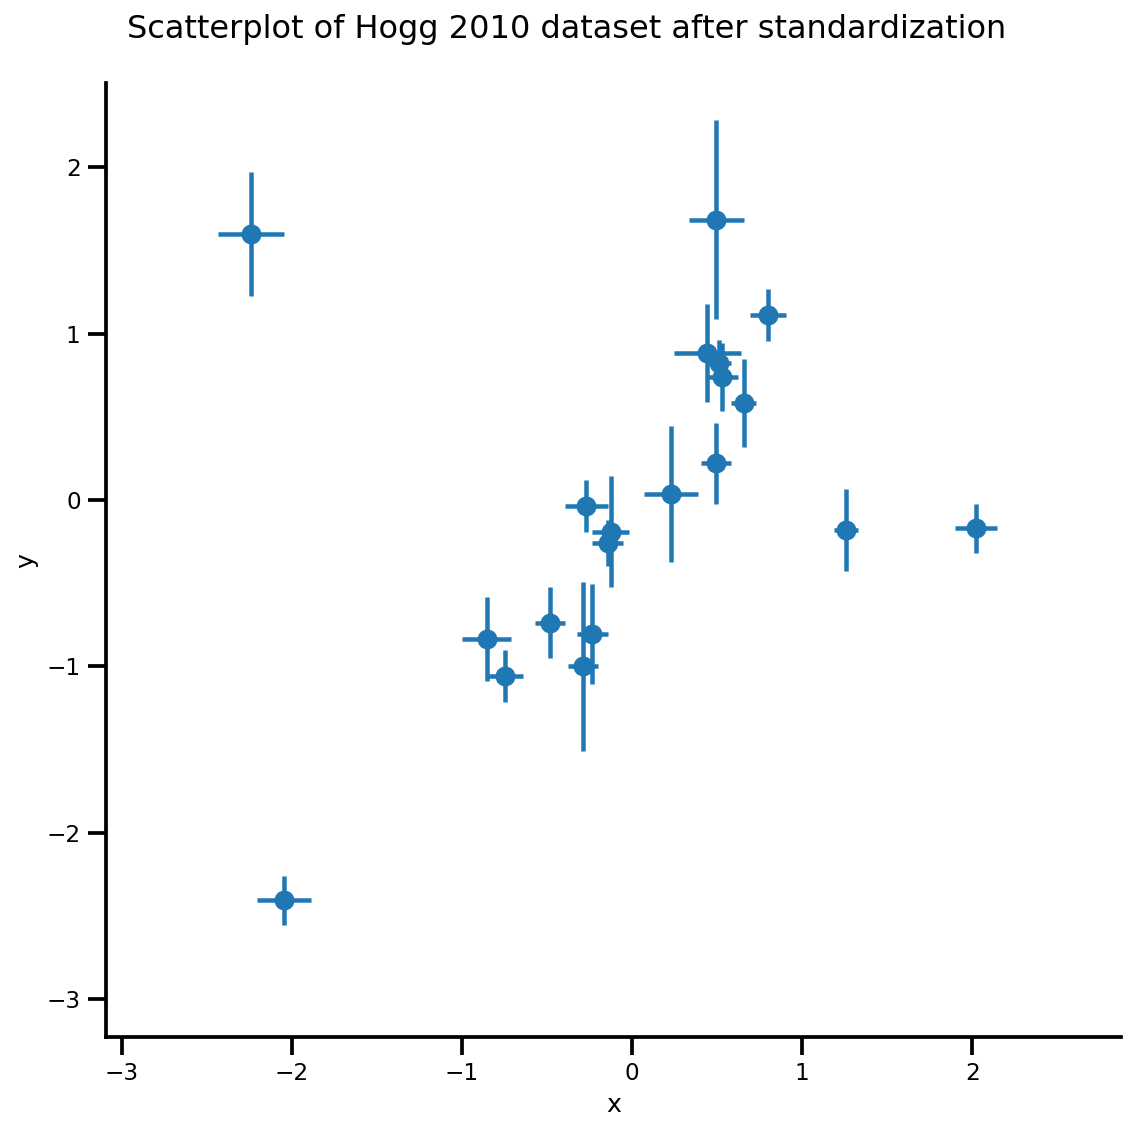

In [0]:
#@title Get data
#@markdown Cut & pasted directly from the `fetch_hogg2010test()` function. It is identical to the original dataset as hardcoded in the Hogg 2010 paper
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

def plot_hoggs(dfhoggs):
  ## create xlims ylims for plotting
  xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5,
           dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
  ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5,
           dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

  ## scatterplot the standardized data
  g = sns.FacetGrid(dfhoggs, size=8)
  _ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
  _ = g.axes[0][0].set_ylim(ylims)
  _ = g.axes[0][0].set_xlim(xlims)

  plt.subplots_adjust(top=0.92)
  _ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)
  return g, xlims, ylims
  
g = plot_hoggs(dfhoggs)

In [0]:
X_np = dfhoggs['x'].values
sigma_y_np = dfhoggs['sigma_y'].values
Y_np = dfhoggs['y'].values

### Conventional OLS Model
Now, let's set up a linear model, a simple intercept + slope regression problem:

In [0]:
mdl_ols = tfd.JointDistributionSequential([
    # b0 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # x ~ Normal(b0+b1*X, 1)
    lambda b1, b0: tfd.Normal(
      # Parameter transformation
      loc=b0 + b1*X_np,
      scale=sigma_y_np)
])

You can then check the graph of the model to see the dependence. Note that `x` is reserved as the name of the last node, and you cannot sure it as your lambda argument in your JointDistributionSequential model.

In [0]:
mdl_ols._resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

Sampling from the model is quite straightforward:

In [0]:
mdl_ols.sample()

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.50225804634794>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.682740126293564>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.33051382,  0.71443618, -1.91085683,  0.89371173, -0.45060957,
        -1.80448758, -0.21357082,  0.07891058, -0.20689721, -0.62690385,
        -0.55225748, -0.11446535, -0.66624497, -0.86913291, -0.93605552,
        -0.83965336, -0.70988597, -0.95813437,  0.15884761, -0.31113434])>]

...which gives a list of tf.Tensor. You can immediately plug it into the log_prob function to compute the log_prob of the model:

In [0]:
prior_predictive_samples = mdl_ols.sample()
mdl_ols.log_prob(prior_predictive_samples)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-4.97502846, -3.98544303, -4.37514505, -3.46933487, -3.80688125,
       -3.42907525, -4.03263074, -3.3646366 , -4.70370938, -4.36178501,
       -3.47823735, -3.94641662, -5.76906319, -4.0944128 , -4.39310708,
       -4.47713894, -4.46307881, -3.98802372, -3.83027747, -4.64777082])>

Hmmm, something is not right here: we should be getting a scalar log_prob! In fact, we can further check to see if something is off by calling the `.log_prob_parts`, which gives the `log_prob` of each nodes in the Graphical model:

In [0]:
mdl_ols.log_prob_parts(prior_predictive_samples)

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.9699239562734849>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-3.459364167569284>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.54574034,  0.4438451 ,  0.05414307,  0.95995326,  0.62240687,
         1.00021288,  0.39665739,  1.06465152, -0.27442125,  0.06750311,
         0.95105078,  0.4828715 , -1.33977506,  0.33487533,  0.03618104,
        -0.04785082, -0.03379069,  0.4412644 ,  0.59901066, -0.2184827 ])>]

...turns out the last node is not being reduce_sum along the i.i.d. dimension/axis! When we do the sum the first two variable is thus incorrectly broadcasted.

The trick here is to use `tfd.Independent` to reinterpreted the batch shape (so that the rest of the axis will be reduced correctly):

In [0]:
mdl_ols_ = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            # b1 shape: (batch_shape), X shape (num_obs): we want result to have
            # shape (batch_shape, num_obs)
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
])

Now, lets check the last node/distribution of the model, you can see that event shape is now correctly interpreted. Note that it might take a bit of trial and error to get the `reinterpreted_batch_ndims` right, but you can always easily print the distribution or sampled tensor to double check the shape!

In [0]:
print(mdl_ols_.sample_distributions()[0][-1])
print(mdl_ols.sample_distributions()[0][-1])

tfp.distributions.Independent("JointDistributionSequential_sample_distributions_IndependentJointDistributionSequential_sample_distributions_Normal", batch_shape=[], event_shape=[20], dtype=float64)
tfp.distributions.Normal("JointDistributionSequential_sample_distributions_Normal", batch_shape=[20], event_shape=[], dtype=float64)


In [0]:
prior_predictive_samples = mdl_ols_.sample()
mdl_ols_.log_prob(prior_predictive_samples)  # <== Getting a scalar correctly

<tf.Tensor: shape=(), dtype=float64, numpy=-2.543425661013286>

#### Other `JointDistribution*` API

In [0]:
mdl_ols_named = tfd.JointDistributionNamed(dict(
    likelihood = lambda b0, b1: tfd.Independent(
        tfd.Normal(
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
    b0         = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    b1         = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
))

mdl_ols_named.log_prob(mdl_ols_named.sample())

<tf.Tensor: shape=(), dtype=float64, numpy=-5.99620966071338>

In [0]:
mdl_ols_named.sample()  # output is a dictionary

{'b0': <tf.Tensor: shape=(), dtype=float64, numpy=0.26364058399428225>,
 'b1': <tf.Tensor: shape=(), dtype=float64, numpy=-0.27209402374432207>,
 'likelihood': <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([ 0.6482155 , -0.39314108,  0.62744764, -0.24587987, -0.20544617,
         1.01465392, -0.04705611, -0.16618702,  0.36410134,  0.3943299 ,
         0.36455291, -0.27822219, -0.24423928,  0.24599518,  0.82731092,
        -0.21983033,  0.56753169,  0.32830481, -0.15713064,  0.23336351])>}

In [0]:
Root = tfd.JointDistributionCoroutine.Root  # Convenient alias.
def model():
  b1 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
  b0 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
  yhat = b0 + b1*X_np
  likelihood = yield tfd.Independent(
        tfd.Normal(loc=yhat, scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    )

mdl_ols_coroutine = tfd.JointDistributionCoroutine(model)
mdl_ols_coroutine.log_prob(mdl_ols_coroutine.sample())

<tf.Tensor: shape=(), dtype=float64, numpy=-4.566678123520463>

In [0]:
mdl_ols_coroutine.sample()  # output is a tuple

(<tf.Tensor: shape=(), dtype=float64, numpy=0.06811002171170354>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.37477064754116807>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.91615096, -0.20244718, -0.47840159, -0.26632479, -0.60441105,
        -0.48977789, -0.32422329, -0.44019322, -0.17072643, -0.20666025,
        -0.55932191, -0.40801868, -0.66893181, -0.24134135, -0.50403536,
        -0.51788596, -0.90071876, -0.47382338, -0.34821655, -0.38559724])>)

#### MLE

And we can now do inference! You can use optimizer to find the Maximum likelihood estimation. 

In [0]:
#@title Define some helper functions

# bfgs and lbfgs currently requries a function that returns both the value and
# gradient re the input.
import functools

def _make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

# Map a list of tensors (e.g., output from JDSeq.sample([...])) to a single tensor
# modify from tfd.Blockwise
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import tensorshape_util

class Mapper:
  """Basically, this is a bijector without log-jacobian correction."""
  def __init__(self, list_of_tensors, list_of_bijectors, event_shape):
    self.dtype = dtype_util.common_dtype(
        list_of_tensors, dtype_hint=tf.float32)
    self.list_of_tensors = list_of_tensors
    self.bijectors = list_of_bijectors
    self.event_shape = event_shape

  def flatten_and_concat(self, list_of_tensors):
    def _reshape_map_part(part, event_shape, bijector):
      part = tf.cast(bijector.inverse(part), self.dtype)
      static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
      if static_rank == 1:
        return part
      new_shape = ps.concat([
          ps.shape(part)[:ps.size(ps.shape(part)) - ps.size(event_shape)], 
          [-1]
      ], axis=-1)
      return tf.reshape(part, ps.cast(new_shape, tf.int32))

    x = tf.nest.map_structure(_reshape_map_part,
                              list_of_tensors,
                              self.event_shape,
                              self.bijectors)
    return tf.concat(tf.nest.flatten(x), axis=-1)

  def split_and_reshape(self, x):
    assertions = []
    message = 'Input must have at least one dimension.'
    if tensorshape_util.rank(x.shape) is not None:
      if tensorshape_util.rank(x.shape) == 0:
        raise ValueError(message)
    else:
      assertions.append(assert_util.assert_rank_at_least(x, 1, message=message))
    with tf.control_dependencies(assertions):
      splits = [
          tf.cast(ps.maximum(1, ps.reduce_prod(s)), tf.int32)
          for s in tf.nest.flatten(self.event_shape)
      ]
      x = tf.nest.pack_sequence_as(
          self.event_shape, tf.split(x, splits, axis=-1))
      def _reshape_map_part(part, part_org, event_shape, bijector):
        part = tf.cast(bijector.forward(part), part_org.dtype)
        static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
        if static_rank == 1:
          return part
        new_shape = ps.concat([ps.shape(part)[:-1], event_shape], axis=-1)
        return tf.reshape(part, ps.cast(new_shape, tf.int32))

      x = tf.nest.map_structure(_reshape_map_part,
                                x, 
                                self.list_of_tensors,
                                self.event_shape,
                                self.bijectors)
    return x

In [0]:
mapper = Mapper(mdl_ols_.sample()[:-1],
                [tfb.Identity(), tfb.Identity()],
                mdl_ols_.event_shape[:-1])

# mapper.split_and_reshape(mapper.flatten_and_concat(mdl_ols_.sample()[:-1]))

In [0]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  # Generate a function closure so that we are computing the log_prob
  # conditioned on the observed data. Note also that tfp.optimizer.* takes a 
  # single tensor as input.
  return -mdl_ols_.log_prob(mapper.split_and_reshape(x) + [Y_np])

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=tf.zeros(2, dtype=dtype),
    tolerance=1e-20,
    x_tolerance=1e-8
)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


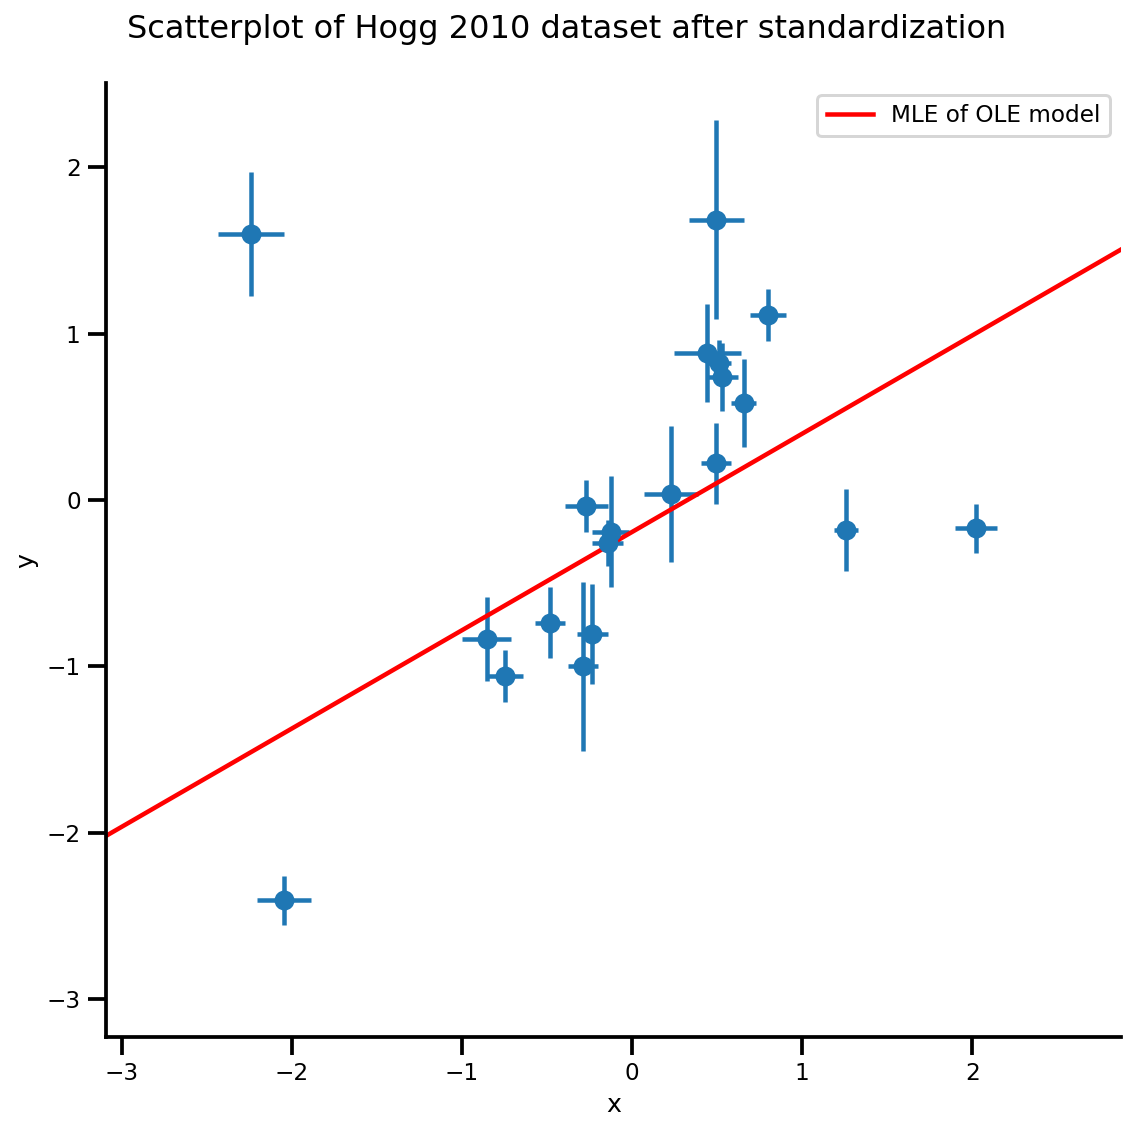

In [0]:
b0est, b1est = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of OLE model')
plt.legend();

#### Batched version model and MCMC

In Bayesian Inference, we usually want to work with MCMC samples, as when the samples are from the posterior, we can plug them into *any* function to compute expectations. However, the MCMC API require us to write models that are batch friendly, and we can check that our model is actually not "batchable" by calling `sample([...])`

```python
mdl_ols_.sample(5)  # <== error as some computation could not be broadcasted.
```

In this case, it is relatively straightforward as we only have a linear function inside our model, expanding the shape should do the trick:

In [0]:
mdl_ols_batch = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            loc=b0[..., tf.newaxis] + b1[..., tf.newaxis]*X_np[tf.newaxis, ...],
            scale=sigma_y_np[tf.newaxis, ...]),
        reinterpreted_batch_ndims=1
    ),
])

mdl_ols_batch._resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

We can again sample and evaluate the log_prob_parts to do some checks:

In [0]:
b0, b1, y = mdl_ols_batch.sample(4)
mdl_ols_batch.log_prob_parts([b0, b1, y])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.25230168, -1.45281432, -1.87110061, -1.07665206])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.07019936, -1.59562117, -2.53387765, -1.01557632])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.45841406,  2.56829635, -4.84973951, -5.59423992])>]

Some side notes:
- We want to work with batch version of the model because it is the fastest for multi-chain MCMC. In cases that you cannot rewrite the model as a batched version (e.g., ODE models), you can map the log_prob function using `tf.map_fn` to achieve the same effect.
- Now `mdl_ols_batch.sample()` might not work as we have scaler prior, as we cannot do `scaler_tensor[:, None]`. The solution here is to expand scaler tensor to rank 1 by wrapping `tfd.Sample(..., sample_shape=1)`.
- It is a good practice to write the model as a function so that you can change set ups like hyperparameters much easier. 

In [0]:
def gen_ols_batch_model(X, sigma, hyperprior_mean=0, hyperprior_scale=1):
  hyper_mean = tf.cast(hyperprior_mean, dtype)
  hyper_scale = tf.cast(hyperprior_scale, dtype)
  return tfd.JointDistributionSequential([
      # b0
      tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
      # b1
      tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
      # likelihood
      lambda b1, b0: tfd.Independent(
          tfd.Normal(
              # Parameter transformation
              loc=b0 + b1*X,
              scale=sigma),
          reinterpreted_batch_ndims=1
      ),
  ], validate_args=True)

mdl_ols_batch = gen_ols_batch_model(X_np[tf.newaxis, ...],
                                    sigma_y_np[tf.newaxis, ...])

_ = mdl_ols_batch.sample()
_ = mdl_ols_batch.sample(4)
_ = mdl_ols_batch.sample([3, 4])

In [0]:
# Small helper function to validate log_prob shape (avoid wrong broadcasting)
def validate_log_prob_part(model, batch_shape=1, observed=-1):
  samples = model.sample(batch_shape)
  logp_part = list(model.log_prob_parts(samples))
  
  # exclude observed node
  logp_part.pop(observed)
  for part in logp_part:
    tf.assert_equal(part.shape, logp_part[-1].shape)

validate_log_prob_part(mdl_ols_batch, 4)

In [0]:
#@title More checks: comparing the generated log_prob fucntion with handwrittent TFP log_prob function. { display-mode: "form" }

def ols_logp_batch(b0, b1, Y):
  b0_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.) # b0
  b1_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.) # b1
  likelihood = tfd.Normal(loc=b0 + b1*X_np[None, :],
                          scale=sigma_y_np) # likelihood
  return tf.reduce_sum(b0_prior.log_prob(b0), axis=-1) +\
         tf.reduce_sum(b1_prior.log_prob(b1), axis=-1) +\
         tf.reduce_sum(likelihood.log_prob(Y), axis=-1)

b0, b1, x = mdl_ols_batch.sample(4)
print(mdl_ols_batch.log_prob([b0, b1, Y_np]).numpy()) 
print(ols_logp_batch(b0, b1, Y_np).numpy())

[ -305.6787416   -453.92745798  -496.29466356 -1163.27748813]
[ -305.6787416   -453.92745798  -496.29466356 -1163.27748813]


#### MCMC using the No-U-Turn Sampler


In [0]:
#@title A common `run_chain` function
@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=500, burnin=50):

  def trace_fn(_, pkr):
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
           )
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn,
      step_size=step_size),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
        inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
  )

  # Sampling from the chain.
  chain_state, sampler_stat = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=hmc,
      trace_fn=trace_fn)
  return chain_state, sampler_stat

In [0]:
nchain = 10
b0, b1, _ = mdl_ols_batch.sample(nchain)
init_state = [b0, b1]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1]]
target_log_prob_fn = lambda *x: mdl_ols_batch.log_prob(x + (Y_np, ))

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
]

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

In [0]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['b0', 'b1']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

In [0]:
az.plot_trace(az_trace);

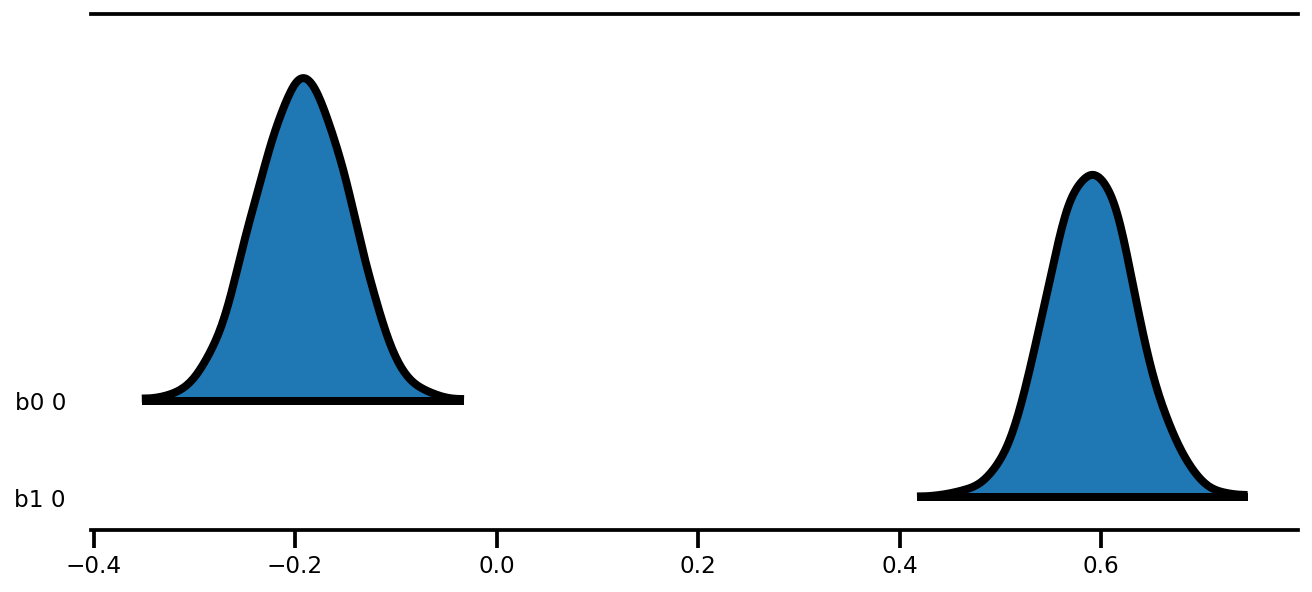

In [0]:
az.plot_forest(az_trace,
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 4));

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  


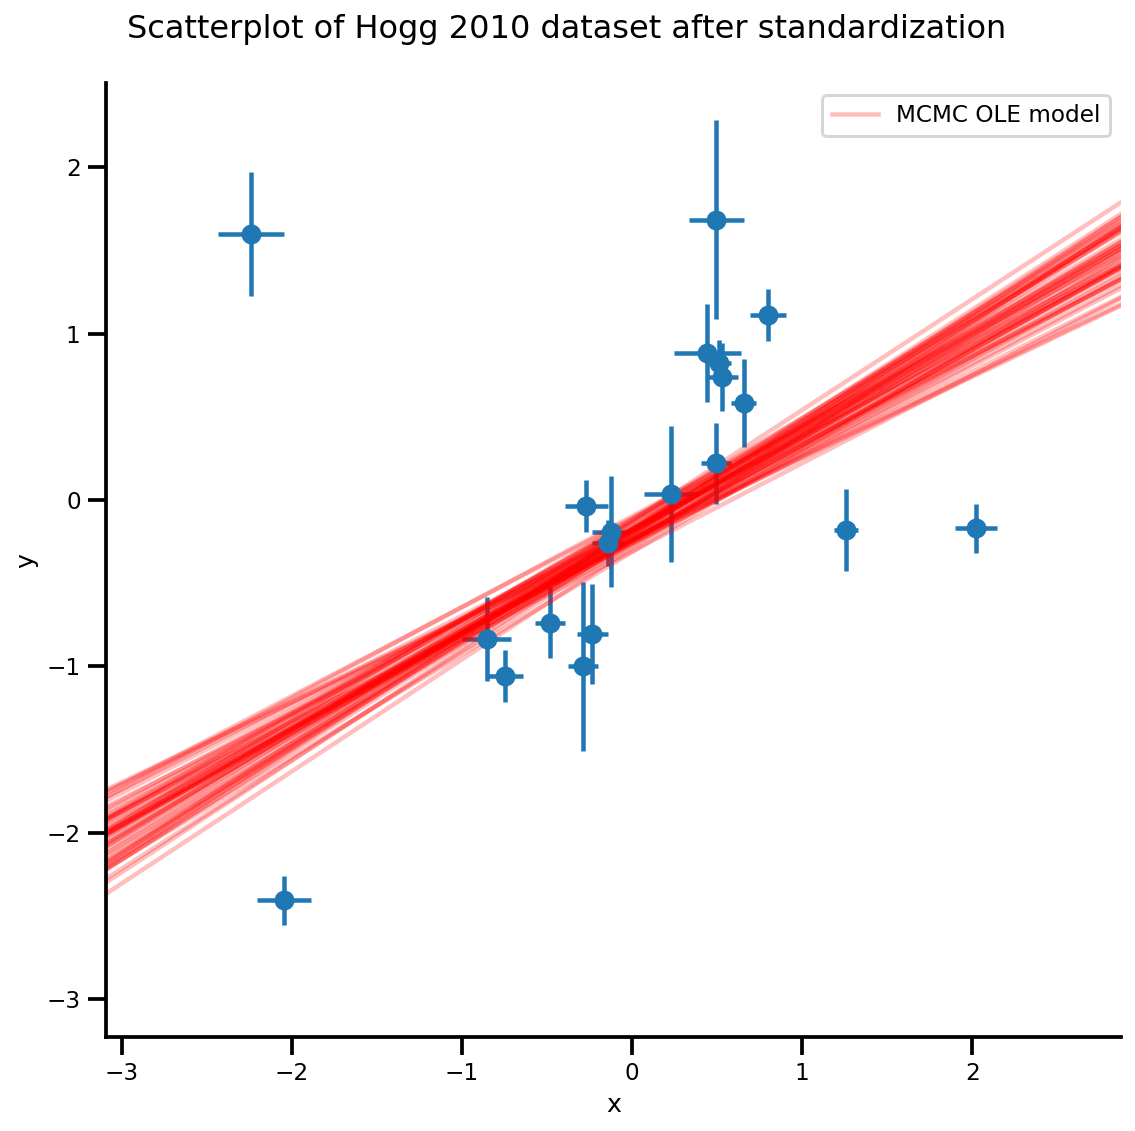

In [0]:
k = 5
b0est, b1est = az_trace.posterior['b0'][:, -k:].values, az_trace.posterior['b1'][:, -k:].values

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T,
                  (np.reshape(b0est, [-1, 1]) + np.reshape(b1est, [-1, 1])*xrange).T,
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC OLE model']);

### Student-T Method

Note that from now on we always work with the batch version of a model

In [0]:
def gen_studentt_model(X, sigma,
                       hyper_mean=0, hyper_scale=1, lower=1, upper=100):
  loc = tf.cast(hyper_mean, dtype)
  scale = tf.cast(hyper_scale, dtype)
  low = tf.cast(lower, dtype)
  high = tf.cast(upper, dtype)
  return tfd.JointDistributionSequential([
      # b0 ~ Normal(0, 1)
      tfd.Sample(tfd.Normal(loc, scale), sample_shape=1),
      # b1 ~ Normal(0, 1)
      tfd.Sample(tfd.Normal(loc, scale), sample_shape=1),
      # df ~ Uniform(a, b)
      tfd.Sample(tfd.Uniform(low, high), sample_shape=1),
      # likelihood ~ StudentT(df, f(b0, b1), sigma_y)
      #   Using Independent to ensure the log_prob is not incorrectly broadcasted.
      lambda df, b1, b0: tfd.Independent(
          tfd.StudentT(df=df, loc=b0 + b1*X, scale=sigma)),
  ], validate_args=True)

mdl_studentt = gen_studentt_model(X_np[tf.newaxis, ...],
                                  sigma_y_np[tf.newaxis, ...])
mdl_studentt._resolve_graph()

(('b0', ()), ('b1', ()), ('df', ()), ('x', ('df', 'b1', 'b0')))

In [0]:
validate_log_prob_part(mdl_studentt, 4)

#### Forward sample (prior predictive sampling)

In [0]:
b0, b1, df, x = mdl_studentt.sample(1000)
x.shape

TensorShape([1000, 20])

#### MLE

In [0]:
# bijector to map contrained parameters to real
a, b = tf.constant(1., dtype), tf.constant(100., dtype),

# Interval transformation
tfp_interval = tfb.Inline(
    inverse_fn=(
        lambda x: tf.math.log(x - a) - tf.math.log(b - x)),
    forward_fn=(
        lambda y: (b - a) * tf.sigmoid(y) + a),
    forward_log_det_jacobian_fn=(
        lambda x: tf.math.log(b - a) - 2 * tf.nn.softplus(-x) - x),
    forward_min_event_ndims=0,
    name="interval")

unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfp_interval,
]

mapper = Mapper(mdl_studentt.sample()[:-1],
                unconstraining_bijectors,
                mdl_studentt.event_shape[:-1])

In [0]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  # Generate a function closure so that we are computing the log_prob
  # conditioned on the observed data. Note also that tfp.optimizer.* takes a 
  # single tensor as input, so we need to do some slicing here:
  return -tf.squeeze(mdl_studentt.log_prob(
      mapper.split_and_reshape(x) + [Y_np]))

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=mapper.flatten_and_concat(mdl_studentt.sample()[:-1]),
    tolerance=1e-20,
    x_tolerance=1e-20
)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


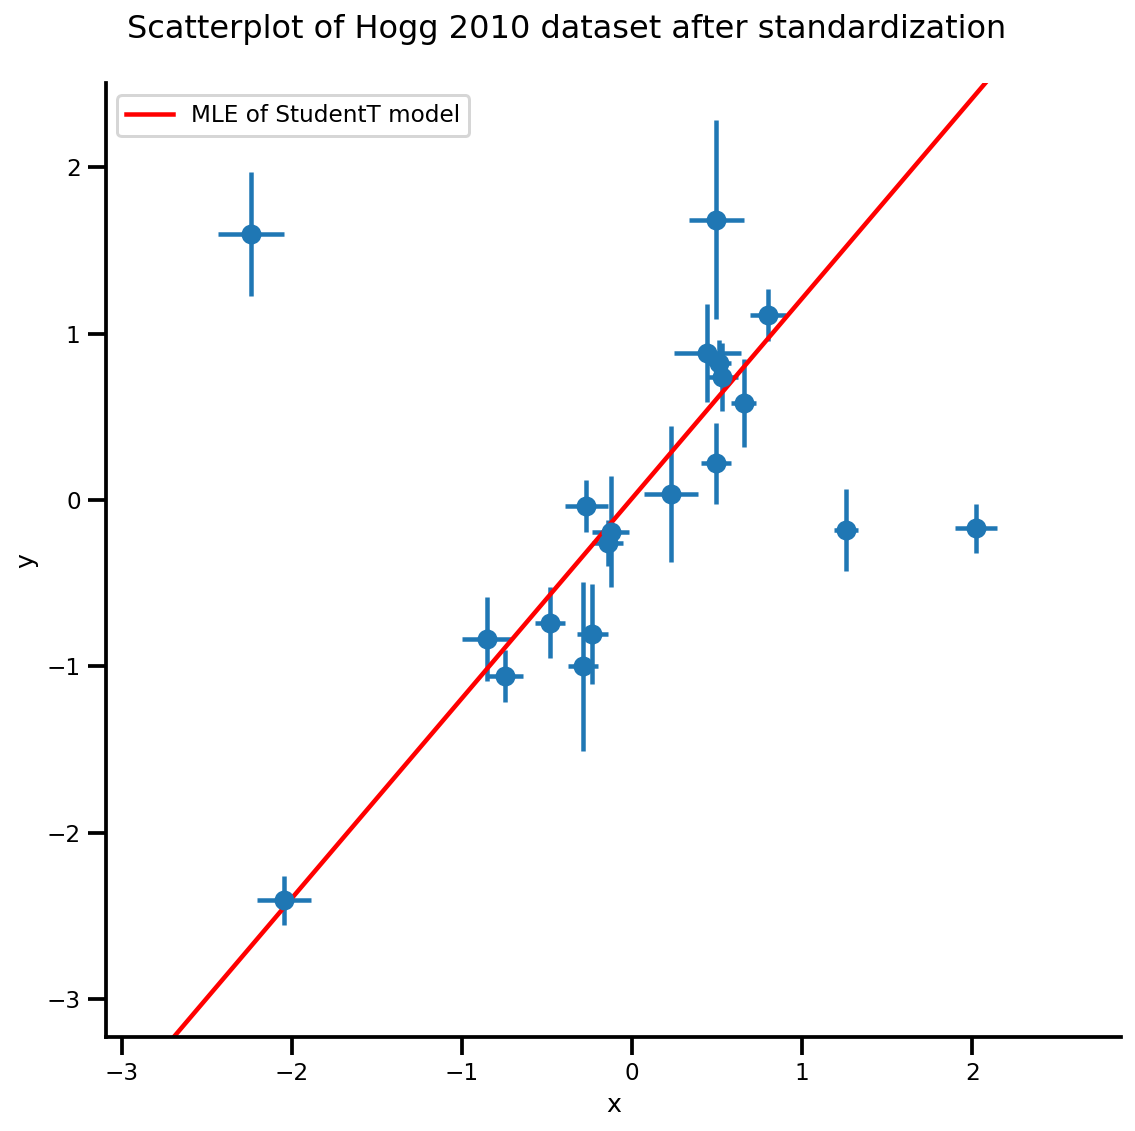

In [0]:
b0est, b1est, dfest = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of StudentT model')
plt.legend();

#### MCMC

In [0]:
nchain = 10
b0, b1, df, _ = mdl_studentt.sample(nchain)
init_state = [b0, b1, df]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1, .05]]

target_log_prob_fn = lambda *x: mdl_studentt.log_prob(x + (Y_np, ))

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors, burnin=100)

In [0]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['b0', 'b1', 'df']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

In [0]:
az.summary(az_trace)

mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
b0[0] -0.006  0.083  -0.151    0.159  ...  2526.0    3272.0    3025.0   1.00
b1[0]  1.205  0.094   1.037    1.401  ...  3325.0    3401.0    2670.0   1.00
df[0]  1.464  0.367   1.001    2.137  ...   529.0     459.0     429.0   1.03

[3 rows x 11 columns]

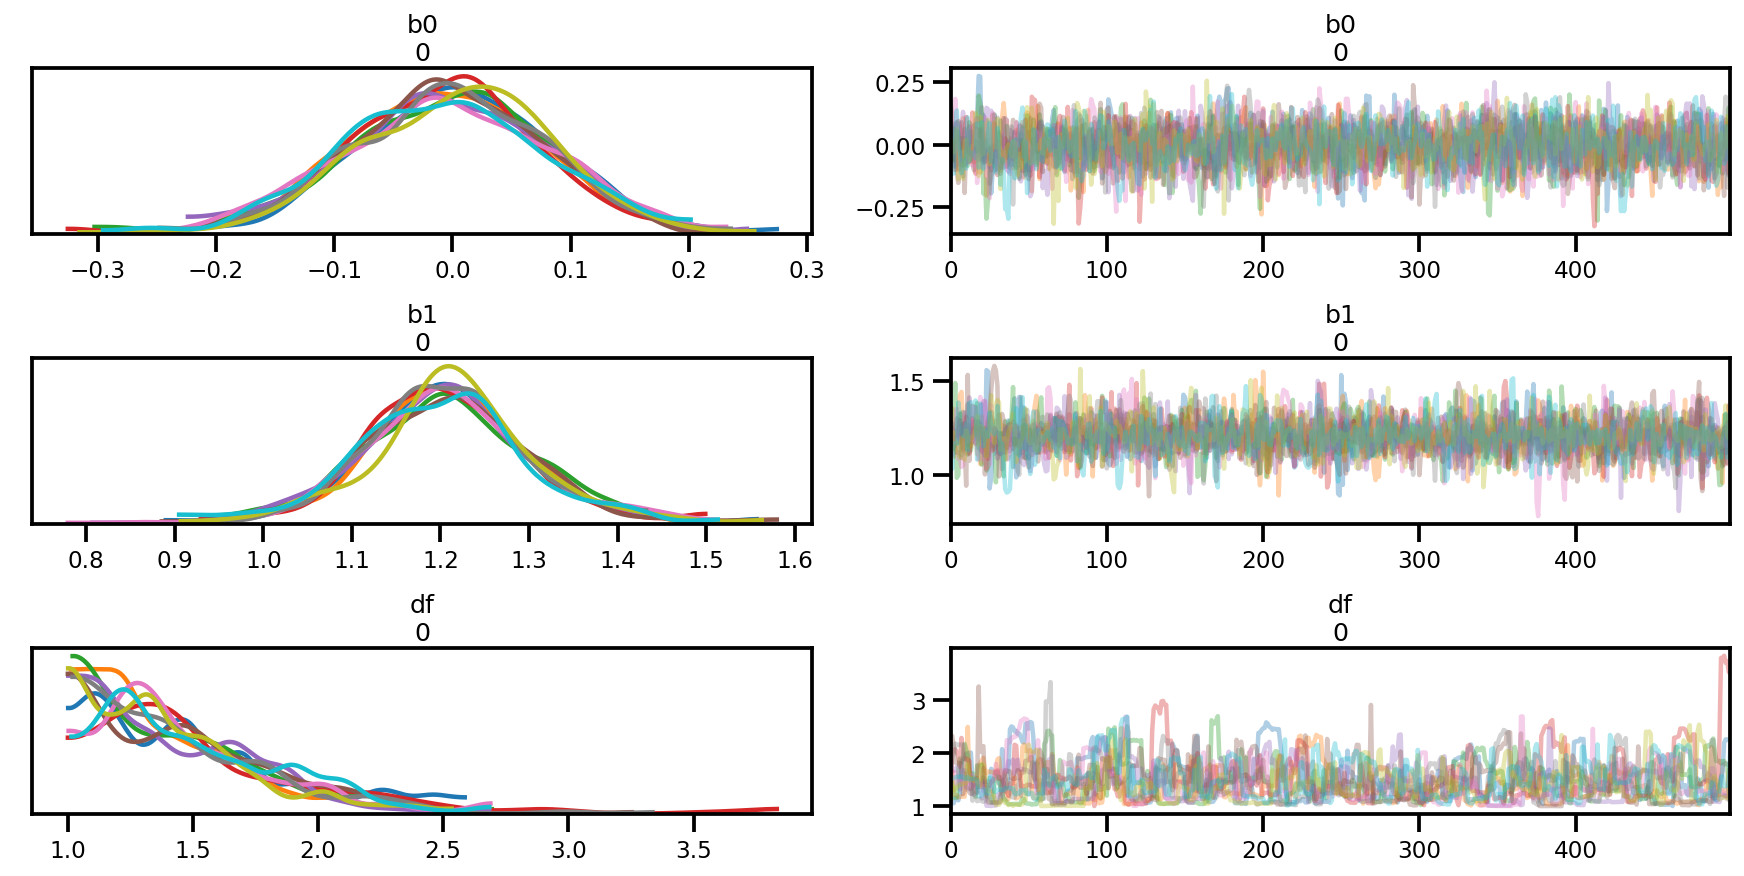

In [0]:
az.plot_trace(az_trace);

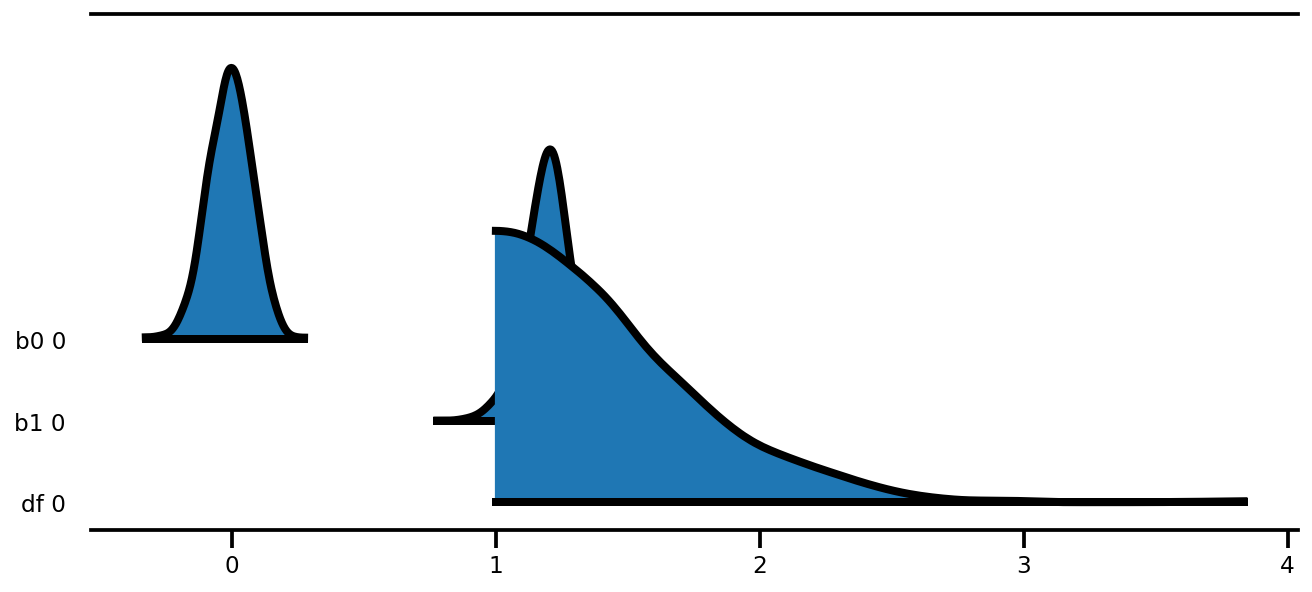

In [0]:
az.plot_forest(az_trace,
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 4));

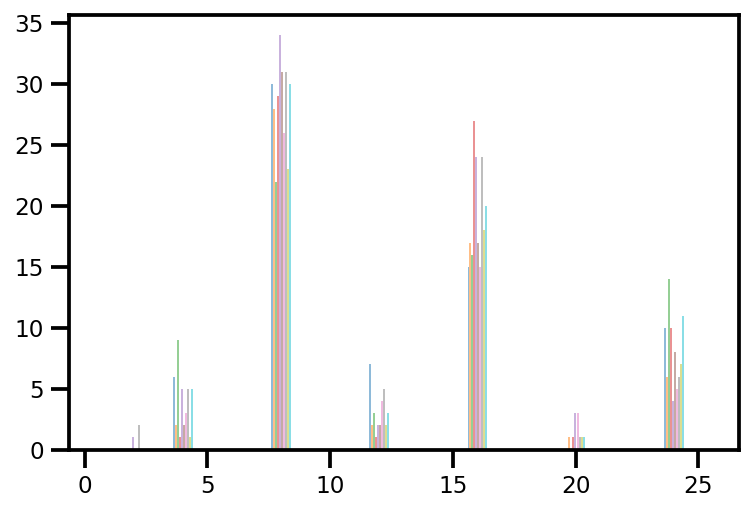

In [0]:
plt.hist(az_trace.sample_stats['tree_size'], np.linspace(.5, 25.5, 26), alpha=.5);

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  


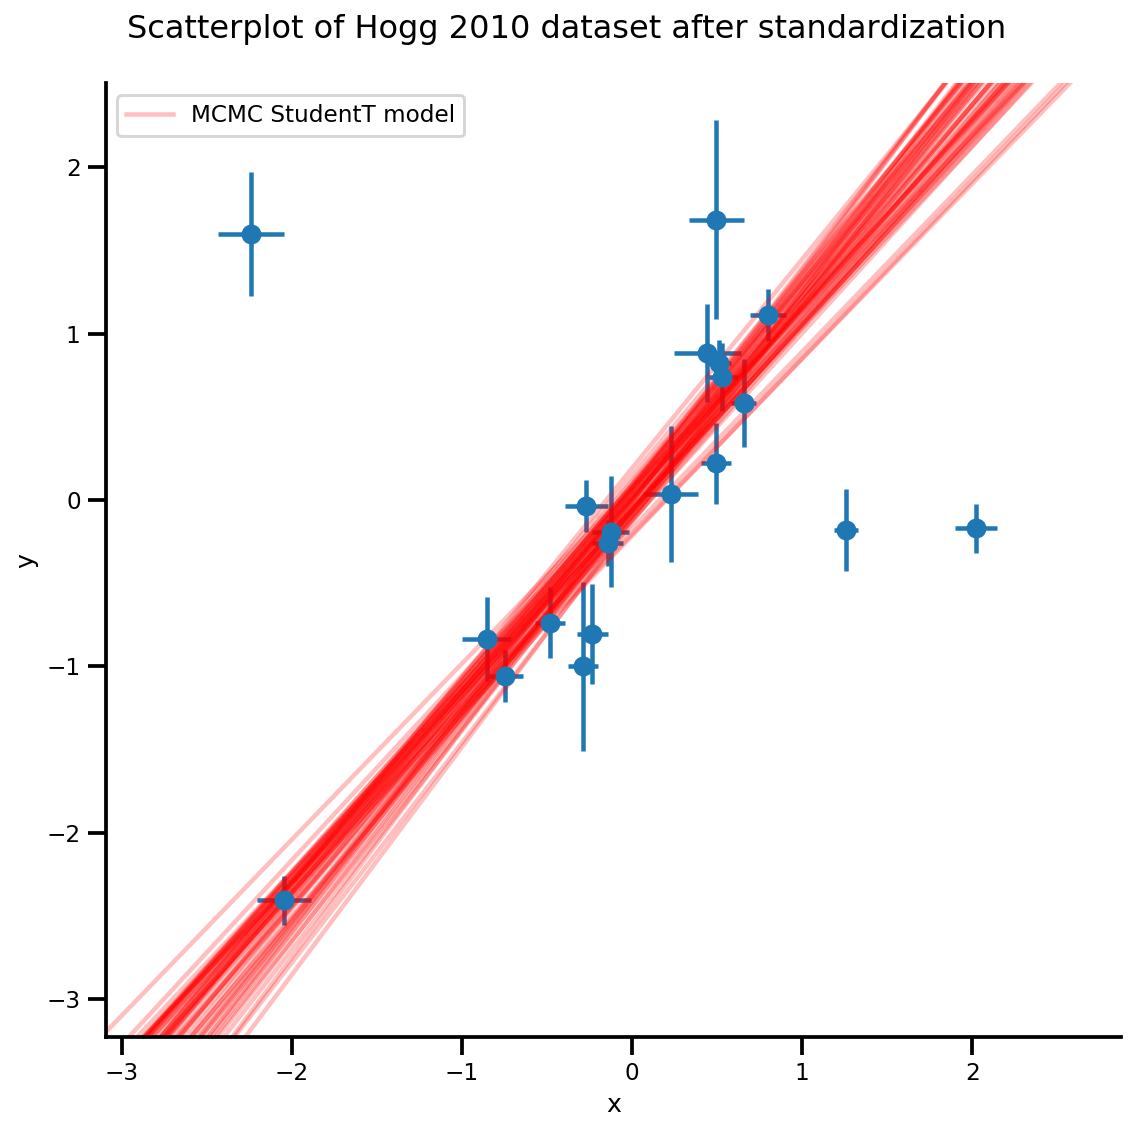

In [0]:
k = 5
b0est, b1est = az_trace.posterior['b0'][:, -k:].values, az_trace.posterior['b1'][:, -k:].values

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T,
                  (np.reshape(b0est, [-1, 1]) + np.reshape(b1est, [-1, 1])*xrange).T,
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC StudentT model']);

## Hierarchical Partial Pooling

From PyMC3 [baseball data for 18 players from Efron and Morris (1975)](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html#Hierarchical-Partial-Pooling)

In [0]:
data = pd.read_table('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/efron-morris-75-data.tsv',
                     sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
n = len(at_bats)

In [0]:
def gen_baseball_model(at_bats, rate=1.5, a=0, b=1):
  return tfd.JointDistributionSequential([
    # phi
    tfd.Uniform(low=tf.cast(a, dtype), high=tf.cast(b, dtype)),
    # kappa_log
    tfd.Exponential(rate=tf.cast(rate, dtype)),
    # thetas
    lambda kappa_log, phi: tfd.Sample(
        tfd.Beta(
            concentration1=tf.exp(kappa_log)*phi,
            concentration0=tf.exp(kappa_log)*(1.0-phi)),
        sample_shape=n
    ),
    # likelihood
    lambda thetas: tfd.Independent(
        tfd.Binomial(
            total_count=tf.cast(at_bats, dtype),
            probs=thetas
        )), 
])

mdl_baseball = gen_baseball_model(at_bats)
mdl_baseball._resolve_graph()

(('phi', ()),
 ('kappa_log', ()),
 ('thetas', ('kappa_log', 'phi')),
 ('x', ('thetas',)))

#### Forward sample (prior predictive sampling)

In [0]:
phi, kappa_log, thetas, y = mdl_baseball.sample(4)
# phi, kappa_log, thetas, y

Again, notice how if you dont use Independent you will end up with log_prob that has wrong batch_shape.

In [0]:
  # check logp
pprint(mdl_baseball.log_prob_parts([phi, kappa_log, thetas, hits]))
print(mdl_baseball.log_prob([phi, kappa_log, thetas, hits]))

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0., 0., 0., 0.])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.1721297 , -0.95946498, -0.72591188,  0.23993813])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([59.35192283,  7.0650634 ,  0.83744911, 74.14370935])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-3279.75191016,  -931.10438484,  -512.59197688, -1131.08043597])>]
tf.Tensor([-3220.22785762  -924.99878641  -512.48043966 -1056.69678849], shape=(4,), dtype=float64)


### MLE

A pretty amazing feature of `tfp.optimizer` is that, you can optimized in parallel for k batch of starting point and specify the `stopping_condition` kwarg: you can set it to `tfp.optimizer.converged_all` to see if they all find the same minimal, or `tfp.optimizer.converged_any` to find a local solution fast.

In [0]:
unconstraining_bijectors = [
    tfb.Sigmoid(),
    tfb.Exp(),
    tfb.Sigmoid(),
]

phi, kappa_log, thetas, y = mdl_baseball.sample(10)

mapper = Mapper([phi, kappa_log, thetas],
                unconstraining_bijectors,
                mdl_baseball.event_shape[:-1])

In [0]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  return -mdl_baseball.log_prob(mapper.split_and_reshape(x) + [hits])

start = mapper.flatten_and_concat([phi, kappa_log, thetas])

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    num_correction_pairs=10,
    initial_position=start,
    # lbfgs actually can work in batch as well
    stopping_condition=tfp.optimizer.converged_any,
    tolerance=1e-50,
    x_tolerance=1e-50,
    parallel_iterations=10,
    max_iterations=200
)

In [0]:
lbfgs_results.converged.numpy(), lbfgs_results.failed.numpy()

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

In [0]:
result = lbfgs_results.position[lbfgs_results.converged & ~lbfgs_results.failed]
result

<tf.Tensor: shape=(0, 20), dtype=float64, numpy=array([], shape=(0, 20), dtype=float64)>

LBFGS did not converged.

In [0]:
if result.shape[0] > 0:
  phi_est, kappa_est, theta_est = mapper.split_and_reshape(result)
  phi_est, kappa_est, theta_est

### MCMC

In [0]:
target_log_prob_fn = lambda *x: mdl_baseball.log_prob(x + (hits, ))

nchain = 4
phi, kappa_log, thetas, _ = mdl_baseball.sample(nchain)
init_state = [phi, kappa_log, thetas]
step_size=[tf.cast(i, dtype=dtype) for i in [.1, .1, .1]]

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
    burnin=200)

In [0]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['phi', 'kappa_log', 'thetas']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

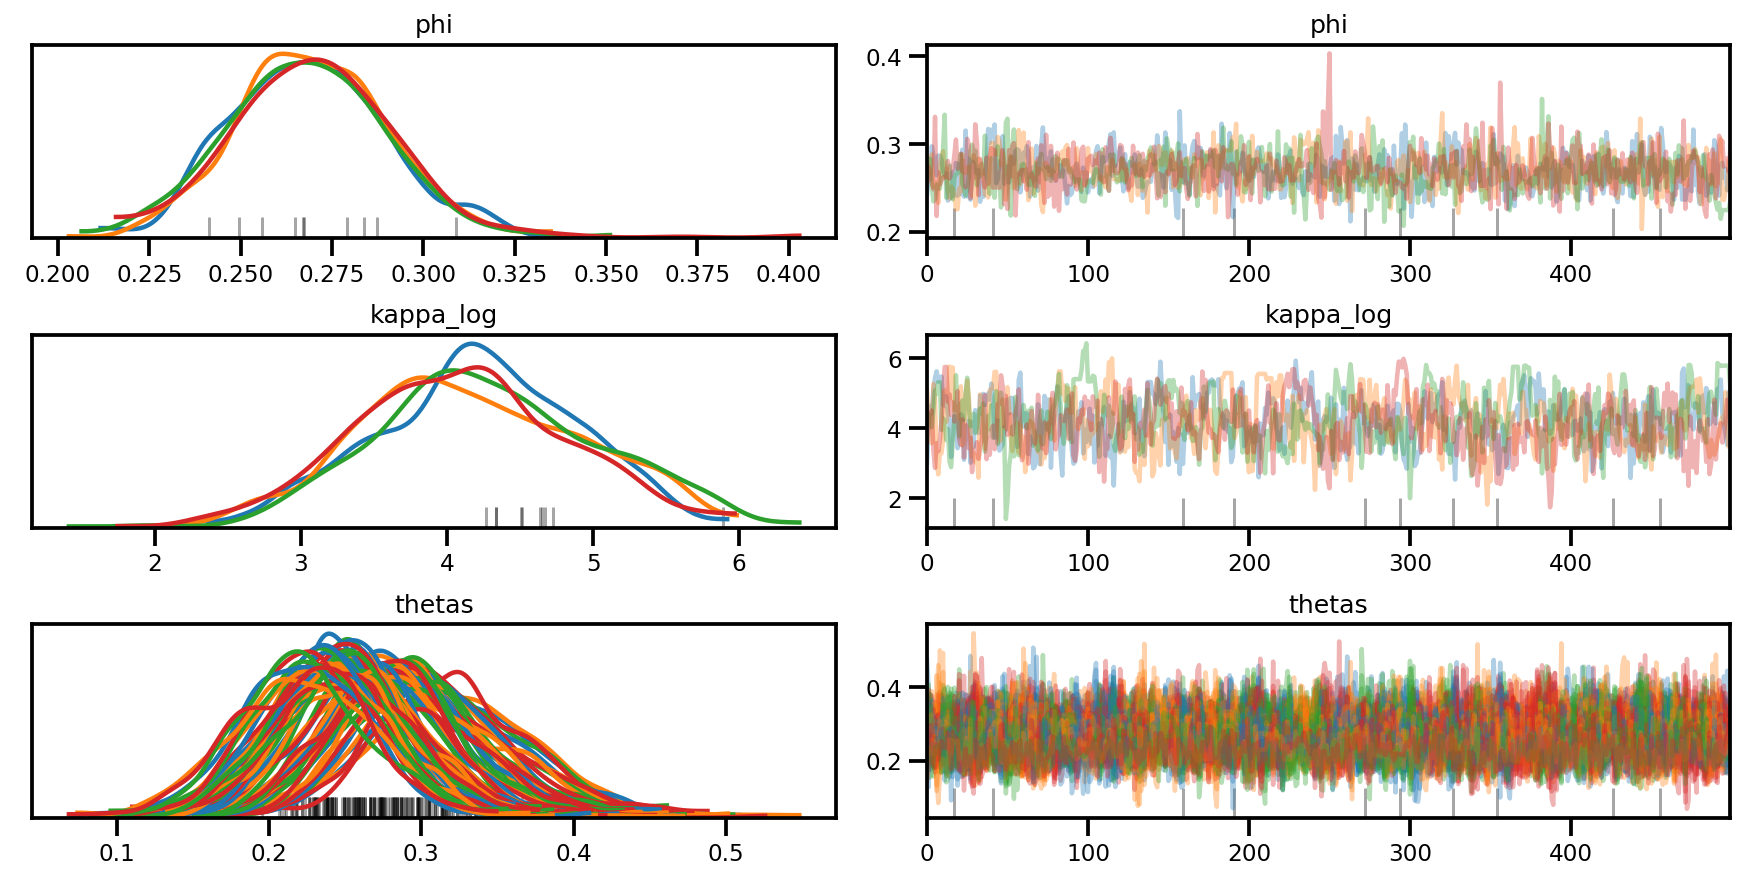

In [0]:
az.plot_trace(az_trace, compact=True);

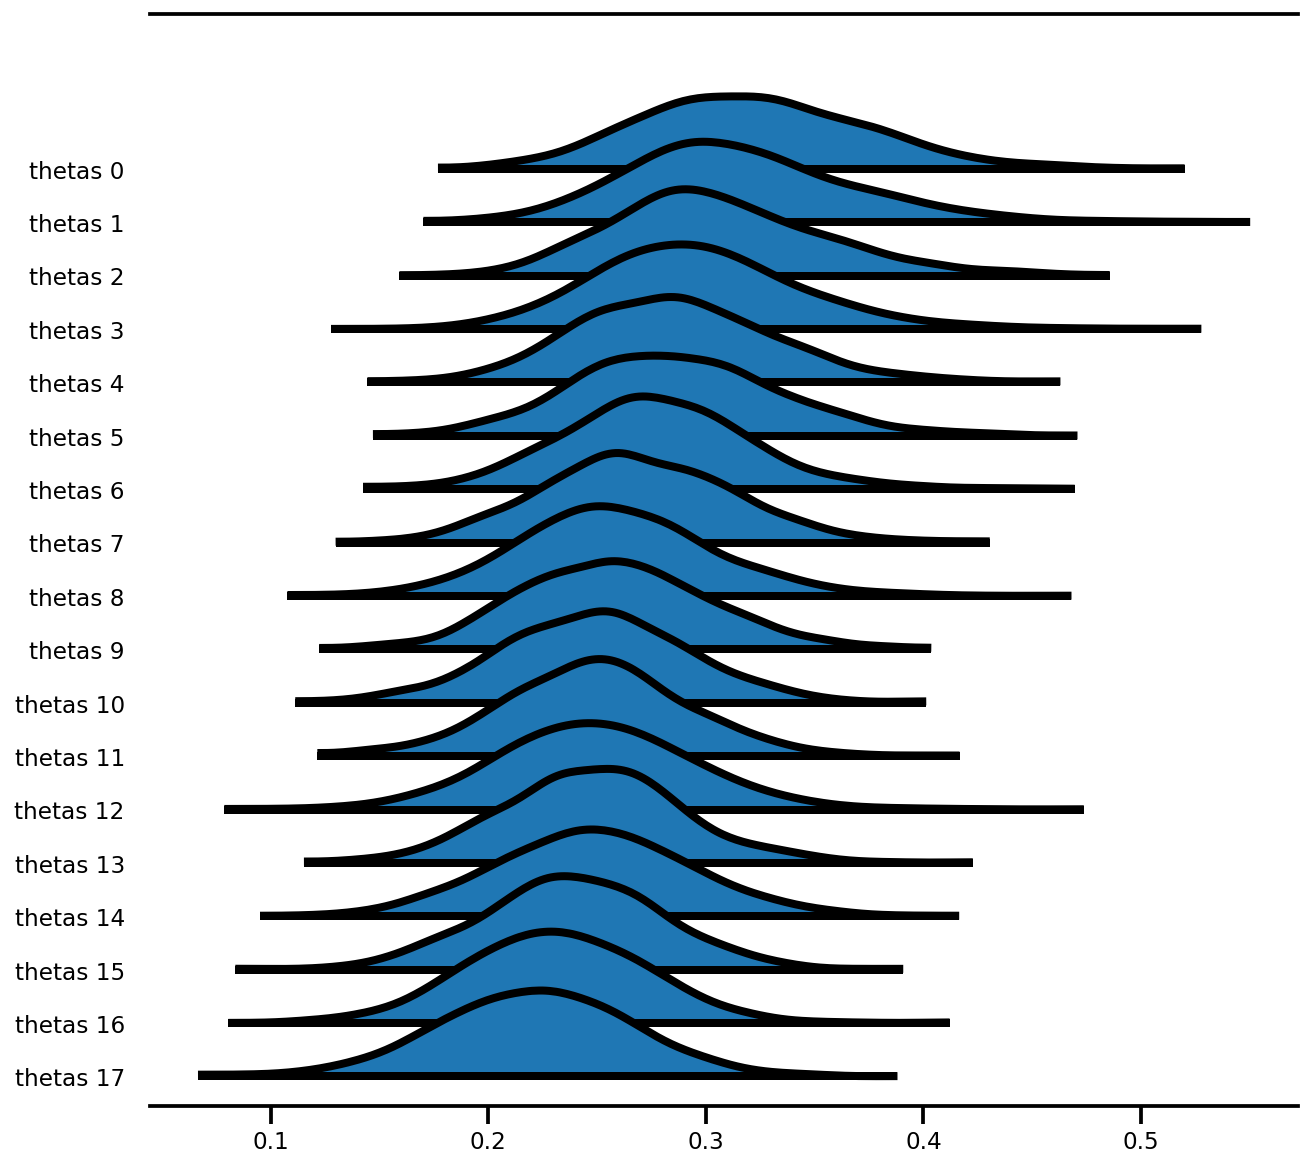

In [0]:
az.plot_forest(az_trace,
               var_names=['thetas'],
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 8));

## Mixed effect model (Radon)
The last model in the PyMC3 doc: [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html)

Some changes in prior (smaller scale etc)

In [0]:
#@title Load raw data and clean up
srrs2 = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/srrs2.dat')

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips

cty = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values.astype('float')

# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

For models with complex transformation, implementing it in a functional style would make writing and testing much easier. Also, it makes programmtically generate log_prob function that conditioned on (mini-batch) of inputted data much easier:



In [0]:
def affine(u_val, x_county, county, floor, gamma, eps, b):
  """Linear equation of the coefficients and the covariates, with broadcasting."""
  return (tf.transpose((gamma[..., 0]
                      + gamma[..., 1]*u_val[:, None]
                      + gamma[..., 2]*x_county[:, None]))
          + tf.gather(eps, county, axis=-1)
          + b*floor)


def gen_radon_model(u_val, x_county, county, floor,
                    mu0=tf.zeros([], dtype, name='mu0')):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([
      # sigma_a
      tfd.HalfCauchy(loc=mu0, scale=5.),
      # eps
      lambda sigma_a: tfd.Sample(
          tfd.Normal(loc=mu0, scale=sigma_a), sample_shape=counties),
      # gamma
      tfd.Sample(tfd.Normal(loc=mu0, scale=100.), sample_shape=3),
      # b
      tfd.Sample(tfd.Normal(loc=mu0, scale=100.), sample_shape=1),
      # sigma_y
      tfd.Sample(tfd.HalfCauchy(loc=mu0, scale=5.), sample_shape=1),
      # likelihood
      lambda sigma_y, b, gamma, eps: tfd.Independent(
          tfd.Normal(
              loc=affine(u_val, x_county, county, floor, gamma, eps, b),
              scale=sigma_y
          ),
          reinterpreted_batch_ndims=1
      ),
  ])

contextual_effect2 = gen_radon_model(
    u.values,  xbar[county], county, floor_measure)

@tf.function(autograph=False)
def unnormalized_posterior_log_prob(sigma_a, gamma, eps, b, sigma_y):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return contextual_effect2.log_prob(
      [sigma_a, gamma, eps, b, sigma_y, log_radon])

assert [4] == unnormalized_posterior_log_prob(
    *contextual_effect2.sample(4)[:-1]).shape

In [0]:
samples = contextual_effect2.sample(4)
pprint([s.shape for s in samples])

[TensorShape([4]),
 TensorShape([4, 85]),
 TensorShape([4, 3]),
 TensorShape([4, 1]),
 TensorShape([4, 1]),
 TensorShape([4, 919])]


In [0]:
contextual_effect2.log_prob_parts(list(samples)[:-1] + [log_radon])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-3.95681828, -2.45693443, -2.53310078, -4.7717536 ])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-328.6021724 , -228.06336744, -231.56752436, -362.53446171])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-17.2439065 , -16.96393645, -18.34225744, -18.29092373])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-5.94765605, -5.91460848, -6.66169402, -5.53894593])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-2.10293999, -4.34186631, -2.10744955, -3.016717  ])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=
 array([-1994490.34498182,   -26158.84209057, -6647137.05241657,
         -269989.08553475])>]

### Variational Inference

One very powerful feature of `JointDistribution*` is that you can generate an approximation easily for VI. For example, to do meanfield ADVI, you simply inspect the graph and replace all the none observed distribution with a Normal distribution.

#### Meanfield ADVI

You can also use the experimential feature in [tensorflow_probability/python/experimental/vi](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/vi) to build variational approximation, which are essentially the same logic used below (i.e., using JointDistribution to build approximation), but with the approximation output in the original space instead of the unbounded space.

In [0]:
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)

In [0]:
# Wrap logp so that all parameters are in the Real domain
# copied and edited from tensorflow_probability/python/mcmc/transformed_kernel.py
unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

unnormalized_log_prob = lambda *x: contextual_effect2.log_prob(x + (log_radon,))

contextual_effect_posterior = make_transformed_log_prob(
    unnormalized_log_prob,
    unconstraining_bijectors,
    direction='forward',
    # TODO(b/72831017): Disable caching until gradient linkage
    # generally works.
    enable_bijector_caching=False)

In [0]:
# debug
if True:
  # Check the two versions of log_prob - they should be different given the Jacobian
  rv_samples = contextual_effect2.sample(4)

  _inverse_transform = make_transform_fn(unconstraining_bijectors, 'inverse')
  _forward_transform = make_transform_fn(unconstraining_bijectors, 'forward')

  pprint([
      unnormalized_log_prob(*rv_samples[:-1]),
      contextual_effect_posterior(*_inverse_transform(rv_samples[:-1])),
      unnormalized_log_prob(
          *_forward_transform(
              tf.zeros_like(a, dtype=dtype) for a in rv_samples[:-1])
      ),
      contextual_effect_posterior(
          *[tf.zeros_like(a, dtype=dtype) for a in rv_samples[:-1]]
      ),
  ])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-4.72500066e+04, -4.05381979e+04, -4.06967364e+08, -2.02443993e+07])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-4.72476455e+04, -4.05341520e+04, -4.06967356e+08, -2.02443966e+07])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1992.10420767, -1992.10420767, -1992.10420767, -1992.10420767])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1992.10420767, -1992.10420767, -1992.10420767, -1992.10420767])>]


In [0]:
# Build meanfield ADVI for a jointdistribution
# Inspect the input jointdistribution and replace the list of distribution with
# a list of Normal distribution, each with the same shape.
def build_meanfield_advi(jd_list, observed_node=-1):
  """
  The inputted jointdistribution needs to be a batch version
  """
  # Sample to get a list of Tensors
  list_of_values = jd_list.sample(1)  # <== sample([]) might not work
  
  # Remove the observed node
  list_of_values.pop(observed_node)
  
  # Iterate the list of Tensor to a build a list of Normal distribution (i.e.,
  # the Variational posterior)
  distlist = []
  for i, value in enumerate(list_of_values):
    dtype = value.dtype
    rv_shape = value[0].shape
    loc = tf.Variable(
        tf.random.normal(rv_shape, dtype=dtype),
        name='meanfield_%s_mu' % i,
        dtype=dtype)
    scale = tfp.util.TransformedVariable(
        tf.fill(rv_shape, value=tf.constant(0.02, dtype)),
        tfb.Softplus(),
        name='meanfield_%s_scale' % i,
    )

    approx_node = tfd.Normal(loc=loc, scale=scale)
    if loc.shape == ():
      distlist.append(approx_node)
    else:
      distlist.append(
          # TODO: make the reinterpreted_batch_ndims more flexible (for 
          # minibatch etc)
          tfd.Independent(approx_node, reinterpreted_batch_ndims=1)
      )

  # pass list to JointDistribution to initiate the meanfield advi
  meanfield_advi = tfd.JointDistributionSequential(distlist)
  return meanfield_advi

In [0]:
advi = build_meanfield_advi(contextual_effect2, observed_node=-1)

# Check the logp and logq
advi_samples = advi.sample(4)
pprint([
  advi.log_prob(advi_samples),
  contextual_effect_posterior(*advi_samples)
  ])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([232.02279696, 219.65361885, 226.08787257, 227.09723591])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-2308.47070583, -2273.51800984, -2314.78947672, -2280.59577322])>]


In [0]:
opt = tf.optimizers.Adam(learning_rate=.1)

@tf.function(experimental_compile=True)
def run_approximation():
  loss_ = tfp.vi.fit_surrogate_posterior(
        contextual_effect_posterior,
        surrogate_posterior=advi,
        optimizer=opt,
        sample_size=10,
        num_steps=300)
  return loss_

loss_ = run_approximation()

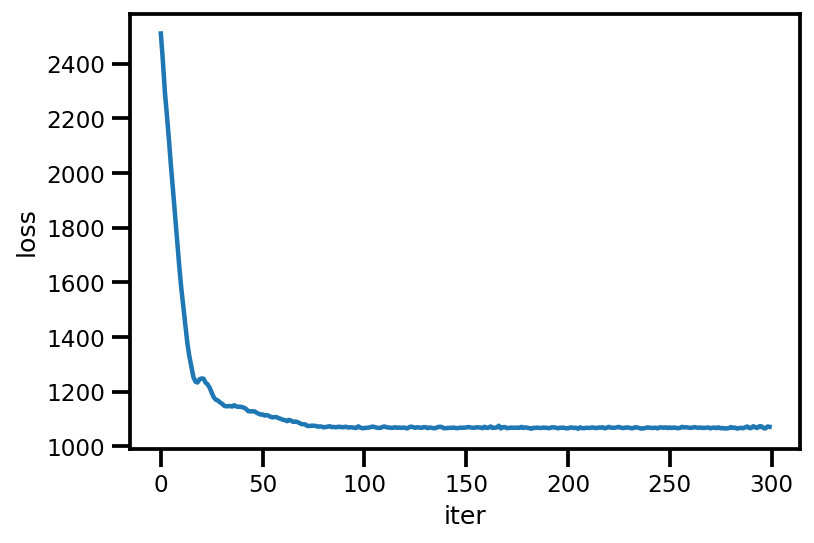

In [0]:
plt.plot(loss_);
plt.xlabel('iter');
plt.ylabel('loss');

In [0]:
graph_info = contextual_effect2._resolve_graph()
approx_param = dict()
free_param = advi.trainable_variables
for i, (rvname, param) in enumerate(graph_info[:-1]):
  approx_param[rvname] = {"mu": free_param[i*2].numpy(),
                          "sd": free_param[i*2+1].numpy()}

In [0]:
approx_param.keys()

dict_keys(['sigma_a', 'eps', 'gamma', 'b', 'sigma_y'])

In [0]:
approx_param['gamma']

{'mu': array([1.43108576, 0.71247731, 0.38345783]),
 'sd': array([-3.72413815, -2.67812764, -2.14937284])}

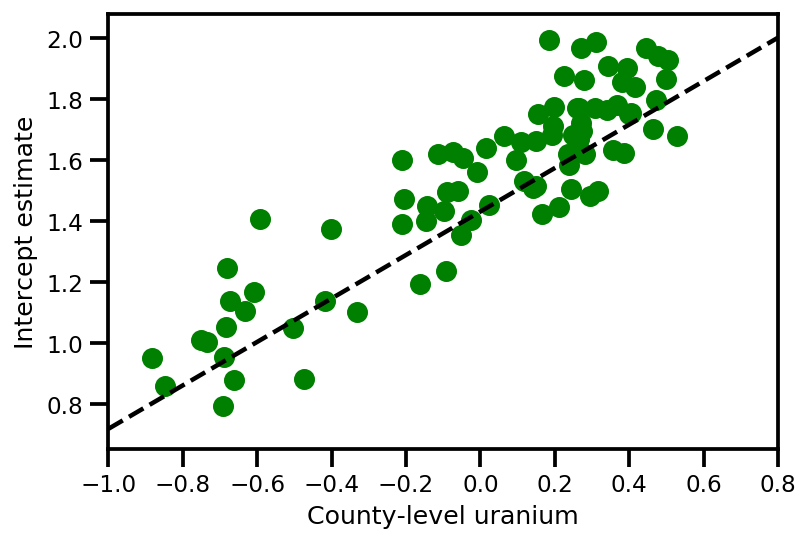

In [0]:
a_means = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps']['mu'][county])
_, index = np.unique(county, return_index=True)
plt.scatter(u.values[index], a_means[index], color='g')

xvals = np.linspace(-1, 0.8)
plt.plot(xvals, 
         approx_param['gamma']['mu'][0]+approx_param['gamma']['mu'][1]*xvals, 
         'k--')
plt.xlim(-1, 0.8)

plt.xlabel('County-level uranium');
plt.ylabel('Intercept estimate');

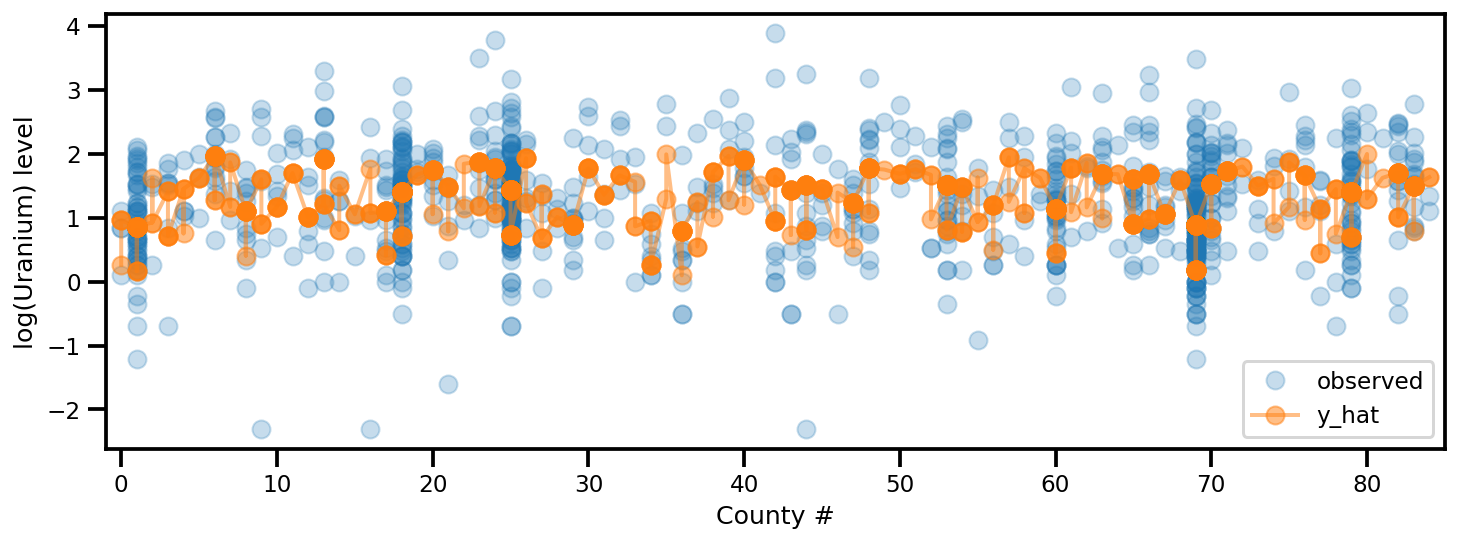

In [0]:
y_est = (approx_param['gamma']['mu'][0] 
        + approx_param['gamma']['mu'][1]*u.values
        + approx_param['gamma']['mu'][2]*xbar[county]
        + approx_param['eps']['mu'][county]
        + approx_param['b']['mu']*floor_measure)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(county, log_radon, 'o', alpha=.25, label='observed')
ax.plot(county, y_est, '-o', lw=2, alpha=.5, label='y_hat')
ax.set_xlim(-1, county.max()+1)
plt.legend(loc='lower right')
ax.set_xlabel('County #')
ax.set_ylabel('log(Uranium) level');

#### FullRank ADVI

For full rank ADVI, we want to approximate the posterior with a multivariate Gaussian.

In [0]:
USE_FULLRANK = True

In [0]:
*prior_tensors, _ = contextual_effect2.sample()

mapper = Mapper(prior_tensors,
                [tfb.Identity() for _ in prior_tensors],
                contextual_effect2.event_shape[:-1])

In [0]:
rv_shape = ps.shape(mapper.flatten_and_concat(mapper.list_of_tensors))
init_val = tf.random.normal(rv_shape, dtype=dtype)
loc = tf.Variable(init_val, name='loc', dtype=dtype)

if USE_FULLRANK:
  # cov_param = tfp.util.TransformedVariable(
  #     10. * tf.eye(rv_shape[0], dtype=dtype),
  #     tfb.FillScaleTriL(),
  #     name='cov_param'
  #     )
  FillScaleTriL = tfb.FillScaleTriL(
        diag_bijector=tfb.Chain([
          tfb.Shift(tf.cast(.01, dtype)),
          tfb.Softplus(),
          tfb.Shift(tf.cast(np.log(np.expm1(1.)), dtype))]),
        diag_shift=None)
  cov_param = tfp.util.TransformedVariable(
      .02 * tf.eye(rv_shape[0], dtype=dtype), 
      FillScaleTriL,
      name='cov_param')
  advi_approx = tfd.MultivariateNormalTriL(
      loc=loc, scale_tril=cov_param)
else:
  # An alternative way to build meanfield ADVI.
  cov_param = tfp.util.TransformedVariable(
      .02 * tf.ones(rv_shape, dtype=dtype),
      tfb.Softplus(),
      name='cov_param'
      )
  advi_approx = tfd.MultivariateNormalDiag(
      loc=loc, scale_diag=cov_param)

contextual_effect_posterior2 = lambda x: contextual_effect_posterior(
    *mapper.split_and_reshape(x)
)

# Check the logp and logq
advi_samples = advi_approx.sample(7)
pprint([
  advi_approx.log_prob(advi_samples),
  contextual_effect_posterior2(advi_samples)
  ])

[<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([211.59448038, 223.74385616, 233.65778236, 233.3654114 ,
       214.65685247, 228.66845619, 243.65067028])>,
 <tf.Tensor: shape=(7,), dtype=float64, numpy=
array([-2644.53797171, -2595.7582418 , -2731.13161429, -2638.69585305,
       -2708.39229038, -2788.38740394, -2725.99810635])>]


In [0]:
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10,
    decay_rate=0.99,
    staircase=True)

opt = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function(experimental_compile=True)
def run_approximation():
  loss_ = tfp.vi.fit_surrogate_posterior(
        contextual_effect_posterior2,
        surrogate_posterior=advi_approx,
        optimizer=opt,
        sample_size=10,
        num_steps=1000)
  return loss_

loss_ = run_approximation()

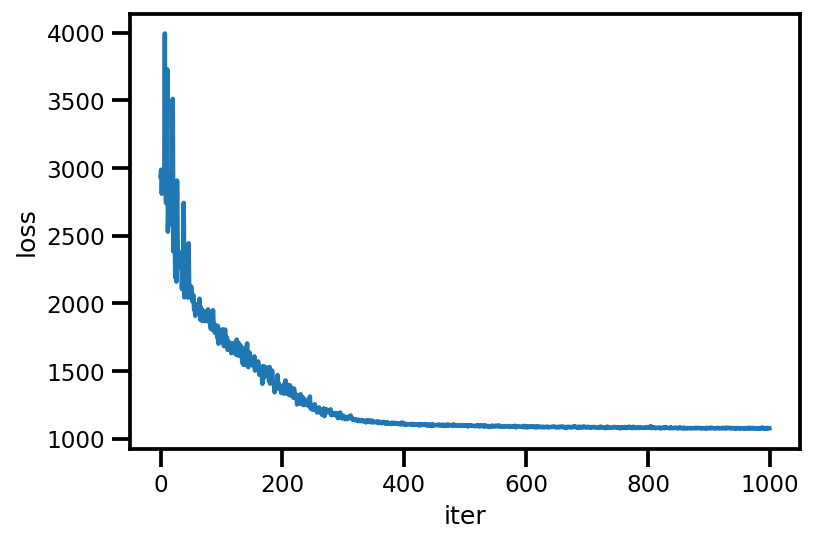

In [0]:
plt.plot(loss_);
plt.xlabel('iter');
plt.ylabel('loss');

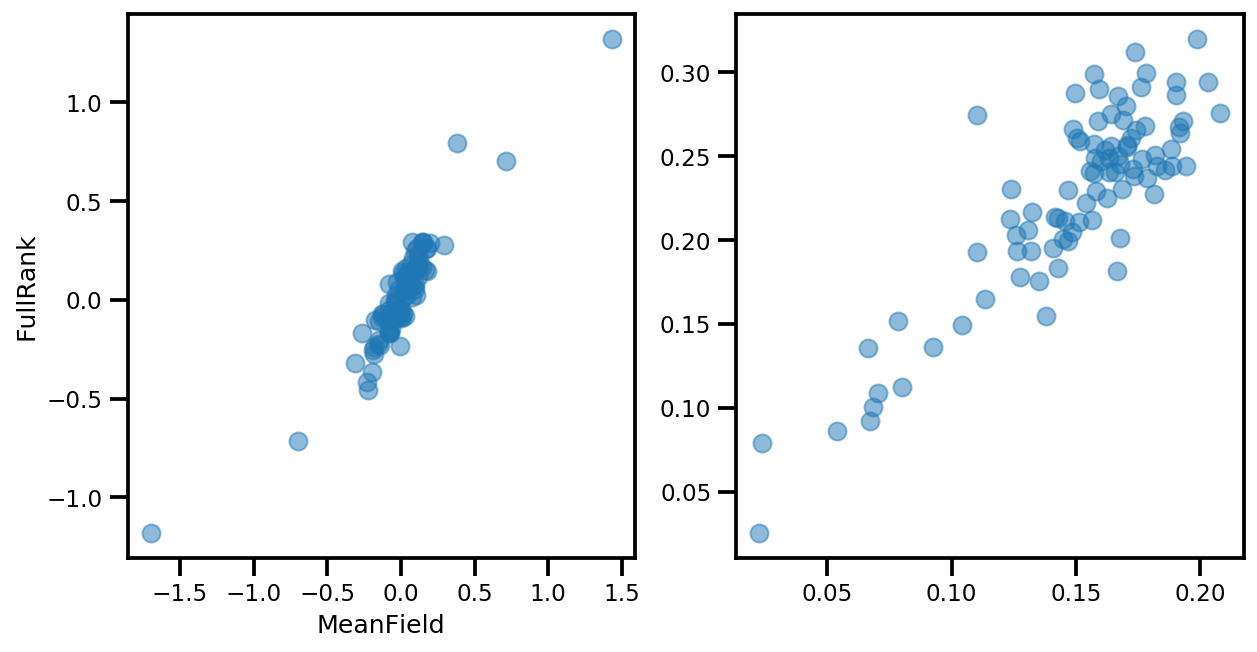

In [0]:
# debug
if True:
  _, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].plot(mapper.flatten_and_concat(advi.mean()), advi_approx.mean(), 'o', alpha=.5)
  ax[1].plot(mapper.flatten_and_concat(advi.stddev()), advi_approx.stddev(), 'o', alpha=.5)
  ax[0].set_xlabel('MeanField')
  ax[0].set_ylabel('FullRank')

In [0]:
graph_info = contextual_effect2._resolve_graph()
approx_param = dict()

free_param_mean = mapper.split_and_reshape(advi_approx.mean())
free_param_std = mapper.split_and_reshape(advi_approx.stddev())
for i, (rvname, param) in enumerate(graph_info[:-1]):
  approx_param[rvname] = {"mu": free_param_mean[i].numpy(),
                          "cov_info": free_param_std[i].numpy()}

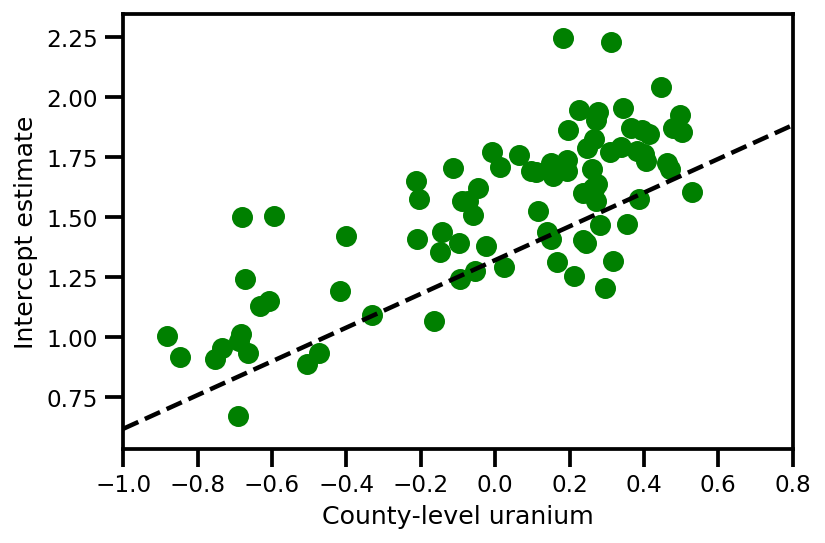

In [0]:
a_means = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps']['mu'][county])
_, index = np.unique(county, return_index=True)
plt.scatter(u.values[index], a_means[index], color='g')

xvals = np.linspace(-1, 0.8)
plt.plot(xvals, 
         approx_param['gamma']['mu'][0]+approx_param['gamma']['mu'][1]*xvals, 
         'k--')
plt.xlim(-1, 0.8)

plt.xlabel('County-level uranium');
plt.ylabel('Intercept estimate');

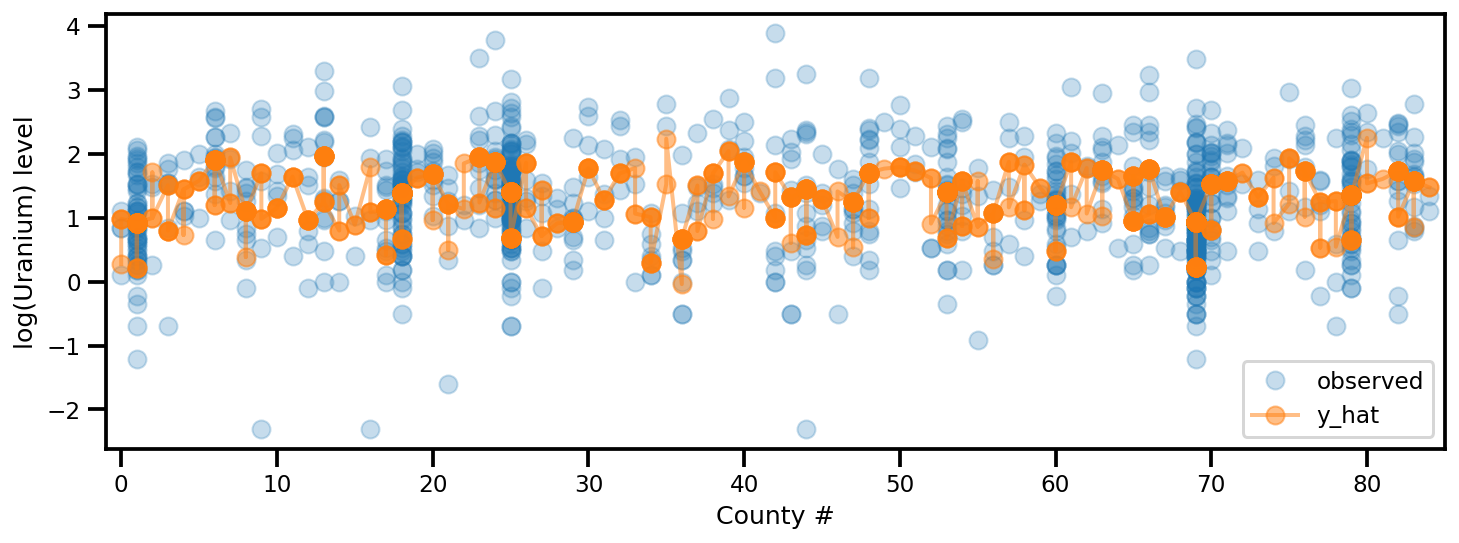

In [0]:
y_est = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps']['mu'][county]
         + approx_param['b']['mu']*floor_measure)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(county, log_radon, 'o', alpha=.25, label='observed')
ax.plot(county, y_est, '-o', lw=2, alpha=.5, label='y_hat')
ax.set_xlim(-1, county.max()+1)
plt.legend(loc='lower right')
ax.set_xlabel('County #')
ax.set_ylabel('log(Uranium) level');

## Beta-Bernoulli Mixture Model

A mixture model where multiple reviewer labeling some items, with unknown (true) latent labels.

In [0]:
dtype = tf.float32

In [0]:
n = 50000    # number of examples reviewed
p_bad_ = 0.1 # fraction of bad events
m = 5        # number of reviewers for each example
rcl_ = .35 + np.random.rand(m)/10
prc_ = .65 + np.random.rand(m)/10

# PARAMETER TRANSFORMATION
tpr = rcl_
fpr = p_bad_*tpr*(1./prc_-1.)/(1.-p_bad_)
tnr = 1 - fpr

# broadcast to m reviewer.
batch_prob = np.asarray([tpr, fpr]).T
mixture = tfd.Mixture(
    tfd.Categorical(
        probs=[p_bad_, 1-p_bad_]),
    [
        tfd.Independent(tfd.Bernoulli(probs=tpr), 1),
        tfd.Independent(tfd.Bernoulli(probs=fpr), 1),
    ])
# Generate reviewer response
X_tf = mixture.sample([n])

# run once to always use the same array as input
# so we can compare the estimation from different
# inference method.
X_np = X_tf.numpy()

In [0]:
# batched Mixture model
mdl_mixture = tfd.JointDistributionSequential([
    tfd.Sample(tfd.Beta(5., 2.), m),
    tfd.Sample(tfd.Beta(2., 2.), m),
    tfd.Sample(tfd.Beta(1., 10), 1),
    lambda p_bad, rcl, prc: tfd.Sample(
        tfd.Mixture(
            tfd.Categorical(probs=tf.concat([p_bad, 1.-p_bad], 1)),
            [
              tfd.Independent(tfd.Bernoulli(
                  probs=rcl), 1),
              tfd.Independent(tfd.Bernoulli(
                  probs=p_bad*rcl*(1./prc-1.)/(1.-p_bad)), 1)
             ]
      ), (n, )), 
    ])

mdl_mixture._resolve_graph()

(('prc', ()), ('rcl', ()), ('p_bad', ()), ('x', ('p_bad', 'rcl', 'prc')))

In [0]:
prc, rcl, p_bad, x = mdl_mixture.sample(4)
x.shape

TensorShape([4, 50000, 5])

In [0]:
mdl_mixture.log_prob_parts([prc, rcl, p_bad, X_np[np.newaxis, ...]])

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([3.0688536, 2.6255634, 3.587345 , 1.6467123], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.02597475,  1.2479572 ,  1.0858296 ,  1.006263  ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.0763867, 2.2435906, 1.6470811, 2.2604134], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-64715.977, -67927.83 , -55699.543, -70249.234], dtype=float32)>]

#### Inference (NUTS)

In [0]:
nchain = 10
prc, rcl, p_bad, _ = mdl_mixture.sample(nchain)
initial_chain_state = [prc, rcl, p_bad]

# Since MCMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfb.Sigmoid(),       # Maps R to [0, 1].
    tfb.Sigmoid(),       # Maps R to [0, 1].
    tfb.Sigmoid(),       # Maps R to [0, 1].
]
step_size = [tf.cast(i, dtype=dtype) for i in [1e-3, 1e-3, 1e-3]]

X_expanded = X_np[np.newaxis, ...]
target_log_prob_fn = lambda *x: mdl_mixture.log_prob(x + (X_expanded, ))

samples, sampler_stat = run_chain(
    initial_chain_state, step_size, target_log_prob_fn, 
    unconstraining_bijectors, burnin=100)

In [0]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['Precision', 'Recall', 'Badness Rate']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

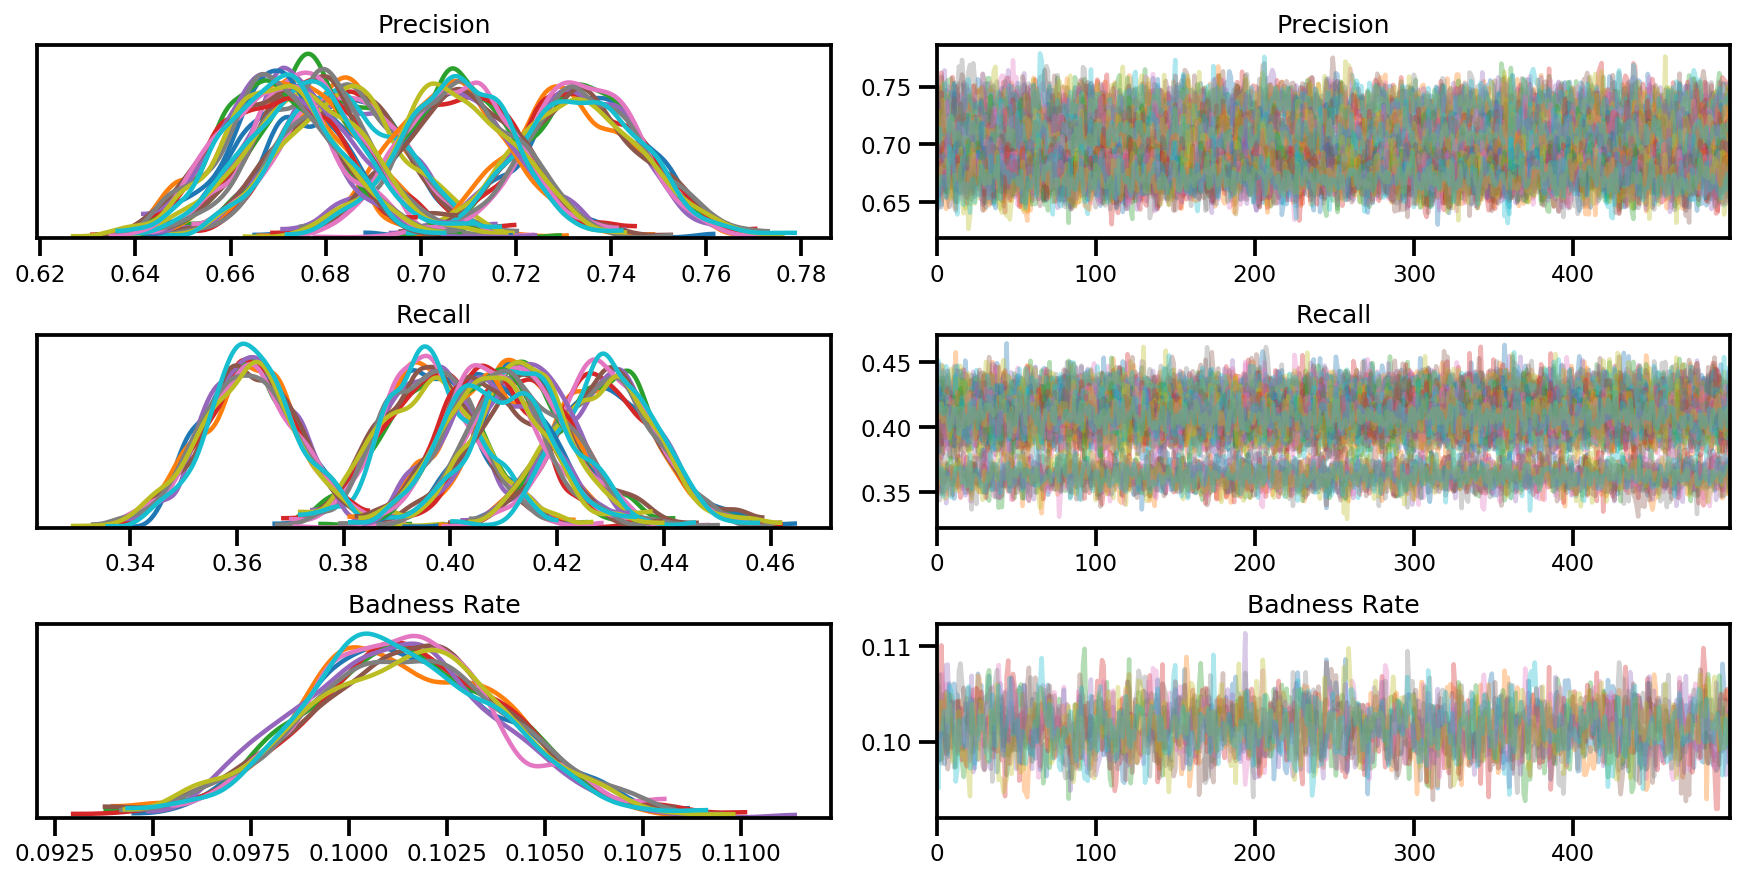

In [0]:
axes = az.plot_trace(az_trace, compact=True);